In [44]:
import torch
import torch.nn as nn
import numpy as np
import time
from tqdm import tqdm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

import scipy.sparse as sparse
import networkx as nx

from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.utils import to_networkx
import os.path as osp

In [3]:
class GraphBaseModel(nn.Module):

    def __init__(self):
        super().__init__()
        pass

    def fit(self):
        pass

In [4]:
def process_nxgraph(graph):
    node2idx = {}
    idx2node = []
    node_size = 0
    for node in graph.nodes():
        node2idx[node] = node_size
        idx2node.append(node)
        node_size += 1
    return idx2node, node2idx

class Regularization(torch.nn.Module):

    def __init__(self, model, gamma=0.01, p=2, device="cpu"):
        '''
        :param model: built model
        :param gamma: coefficient
        :param p: L2 regularization if p=0, L1 regularization if p=1
        '''
        super().__init__()
        if gamma <= 0:
            print("param weight_decay can not be <= 0")
            exit(0)
        self.model = model
        self.gamma = gamma
        self.p = p
        self.device = device
        self.weight_list = self.get_weight_list(model) # Get list of parameters
        self.weight_info = self.get_weight_info(self.weight_list) # Parameter information

    def to(self, device):
        super().to(device)
        self.device = device
        return self

    def forward(self, model):
        self.weight_list = self.get_weight_list(model)
        reg_loss = self.regulation_loss(self.weight_list, self.gamma, self.p)
        return reg_loss

    def regulation_loss(self, weight_list, gamma, p=2):
        reg_loss = 0
        for name, w in weight_list:
            l2_reg = torch.norm(w, p=p)
            reg_loss += l2_reg
        reg_loss = reg_loss * gamma
        return reg_loss

    def get_weight_list(self, model):
        weight_list = []
        # Returns the name of the parameter and the parameter itself
        for name, param in model.named_parameters():
            # Only weight is taken, bias is not taken
            if 'weight' in name:
                weight = (name, param)
                weight_list.append(weight)
        return weight_list

    def get_weight_info(self, weight_list):
        # Name of the parameter being normalized
        print("#"*10, "regulations weight", "#"*10)
        for name, param in weight_list:
            print(name)
        print("#"*25)

In [6]:
class SDNEModel(torch.nn.Module):

    def __init__(self, input_dim, hidden_layers, alpha, beta, device="cpu"):
        '''
        Structural Deep Network Embedding（SDNE）
        :param input_dim: Number of nodes, node_size
        :param hidden_layers: AutoEncoder intermediate layers
        :param alpha: Coefficient for 1st_loss
        :param beta: Penalty for non-zero items in 2nd_loss
        :param device:
        '''
        super(SDNEModel, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.device = device
        input_dim_copy = input_dim
        layers = []
        for layer_dim in hidden_layers:
            layers.append(torch.nn.Linear(input_dim, layer_dim))
            layers.append(torch.nn.ReLU())
            input_dim = layer_dim
        self.encoder = torch.nn.Sequential(*layers)

        layers = []
        for layer_dim in reversed(hidden_layers[:-1]):
            layers.append(torch.nn.Linear(input_dim, layer_dim))
            layers.append(torch.nn.ReLU())
            input_dim = layer_dim
        # Add layer for input_dim
        layers.append(torch.nn.Linear(input_dim, input_dim_copy))
        layers.append(torch.nn.ReLU())
        self.decoder = torch.nn.Sequential(*layers)
        # It is hard to regularize just weights in torch
        # self.regularize = Regularization(self.encoder, weight_decay=gamma).to(self.device) + Regularization(self.decoder,weight_decay=gamma).to(self.device)


    def forward(self, A, L):
        '''
        The link matrix and Laplace matrix of the input node, the main calculation method refers to the paper
        :param A: adjacency_matrix, dim=(m, n)
        :param L: laplace_matrix, dim=(m, m)
        :return:
        '''
        Y = self.encoder(A)
        A_hat = self.decoder(Y)
        # loss_2nd second-order proximity loss function
        beta_matrix = torch.ones_like(A)
        mask = A != 0
        beta_matrix[mask] = self.beta
        loss_2nd = torch.mean(torch.sum(torch.pow((A - A_hat) * beta_matrix, 2), dim=1))
        # loss_1st first-order similarity loss function Paper formula (9) alpha * 2 *tr(Y^T L Y)
        loss_1st =  self.alpha * 2 * torch.trace(torch.matmul(torch.matmul(Y.transpose(0,1), L), Y))
        return loss_2nd + loss_1st

In [106]:
class SDNE(GraphBaseModel):

    def __init__(self, graph, hidden_layers=None, alpha=1e-5, beta=5, gamma=1e-5, device="cpu"):
        super().__init__()
        self.graph = graph
        self.idx2node, self.node2idx = process_nxgraph(graph)
        self.node_size = graph.number_of_nodes()
        self.edge_size = graph.number_of_edges()
        self.sdne = SDNEModel(self.node_size, hidden_layers, alpha, beta)
        self.device = device
        self.embeddings = {}
        self.gamma = gamma

        adjacency_matrix, laplace_matrix = self.__create_adjacency_laplace_matrix()
        self.adjacency_matrix = torch.from_numpy(adjacency_matrix.toarray()).float().to(self.device)
        self.laplace_matrix = torch.from_numpy(laplace_matrix.toarray()).float().to(self.device)

    def fit(self, batch_size=512, epochs=1, initial_epoch=0, verbose=1):
        num_samples = self.node_size
        self.sdne.to(self.device)
        optimizer = torch.optim.Adam(self.sdne.parameters())
        if self.gamma:
            regularization = Regularization(self.sdne, gamma=self.gamma)
        if batch_size >= self.node_size:
            batch_size = self.node_size
            print('batch_size({0}) > node_size({1}),set batch_size = {1}'.format(
                batch_size, self.node_size))
            for epoch in range(initial_epoch, epochs):
                loss_epoch = 0
                optimizer.zero_grad()
                loss = self.sdne(self.adjacency_matrix, self.laplace_matrix)
                if self.gamma:
                    reg_loss = regularization(self.sdne)
                    # print("reg_loss:", reg_loss.item(), reg_loss.requires_grad)
                    loss = loss + reg_loss
                loss_epoch += loss.item()
                loss.backward()
                optimizer.step()
                if verbose > 0:
                    print('Epoch {0}, loss {1} . >>> Epoch {2}/{3}'.format(epoch + 1, round(loss_epoch / num_samples, 4), epoch+1, epochs))
        else:
            steps_per_epoch = (self.node_size - 1) // batch_size + 1
            for epoch in range(initial_epoch, epochs):
                loss_epoch = 0
                for i in range(steps_per_epoch):
                    idx = np.arange(i * batch_size, min((i+1) * batch_size, self.node_size))
                    A_train = self.adjacency_matrix[idx, :]
                    L_train = self.laplace_matrix[idx][:,idx]
                    # print(A_train.shape, L_train.shape)
                    optimizer.zero_grad()
                    loss = self.sdne(A_train, L_train)
                    loss_epoch += loss.item()
                    loss.backward()
                    optimizer.step()

                if verbose > 0:
                    print('Epoch {0}, loss {1} . >>> Epoch {2}/{3}'.format(epoch + 1, round(loss_epoch / num_samples, 4),
                                                                         epoch + 1, epochs))

    def get_embeddings(self):
        if not self.embeddings:
            self.__get_embeddings()
        embeddings = self.embeddings
        return embeddings

    def __get_embeddings(self):
        embeddings = {}
        with torch.no_grad():
            self.sdne.eval()
            embed = self.sdne.encoder(self.adjacency_matrix)
            for i, embedding in enumerate(embed.numpy()):
                embeddings[self.idx2node[i]] = embedding
        self.embeddings = embeddings


    def __create_adjacency_laplace_matrix(self):
        node_size = self.node_size
        node2idx = self.node2idx
        adjacency_matrix_data = []
        adjacency_matrix_row_index = []
        adjacency_matrix_col_index = []
        for edge in self.graph.edges():
            v1, v2 = edge
            edge_weight = self.graph[v1][v2].get("weight", 1.0)
            adjacency_matrix_data.append(edge_weight)
            adjacency_matrix_row_index.append(node2idx[v1])
            adjacency_matrix_col_index.append(node2idx[v2])
        adjacency_matrix = sparse.csr_matrix((adjacency_matrix_data,
                                              (adjacency_matrix_row_index, adjacency_matrix_col_index)),
                                             shape=(node_size, node_size))
        # L = D - A        
        # Calculate degrees
        adjacency_matrix_ = sparse.csr_matrix((adjacency_matrix_data+adjacency_matrix_data,
                                               (adjacency_matrix_row_index+adjacency_matrix_col_index,
                                                adjacency_matrix_col_index+adjacency_matrix_row_index)),
                                              shape=(node_size, node_size))
        degree_matrix = sparse.diags(adjacency_matrix_.sum(axis=1).flatten().tolist()[0])
        laplace_matrix = degree_matrix - adjacency_matrix_
        return adjacency_matrix, laplace_matrix

In [107]:
# Loading Cora dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device)
])
obj = Planetoid(osp.join('data', 'Planetoid'),
                  'Cora', transform=transform)
G = to_networkx(obj[0])
labels = obj[0].y.cpu().detach().numpy()

In [132]:
# Model train
model = SDNE(G, hidden_layers=[128, 64], alpha=1e-5, beta=15)
model.fit(batch_size=128, epochs=100)
embeddings = model.get_embeddings()

########## regulations weight ##########
encoder.0.weight
encoder.2.weight
decoder.0.weight
decoder.2.weight
#########################
Epoch 1, loss 6.5862 . >>> Epoch 1/100
Epoch 2, loss 6.0032 . >>> Epoch 2/100
Epoch 3, loss 5.7308 . >>> Epoch 3/100
Epoch 4, loss 5.578 . >>> Epoch 4/100
Epoch 5, loss 5.4635 . >>> Epoch 5/100
Epoch 6, loss 5.2567 . >>> Epoch 6/100
Epoch 7, loss 4.9978 . >>> Epoch 7/100
Epoch 8, loss 4.7321 . >>> Epoch 8/100
Epoch 9, loss 4.5448 . >>> Epoch 9/100
Epoch 10, loss 4.404 . >>> Epoch 10/100
Epoch 11, loss 4.3536 . >>> Epoch 11/100
Epoch 12, loss 4.3104 . >>> Epoch 12/100
Epoch 13, loss 4.2389 . >>> Epoch 13/100
Epoch 14, loss 4.1867 . >>> Epoch 14/100
Epoch 15, loss 4.1891 . >>> Epoch 15/100
Epoch 16, loss 4.1708 . >>> Epoch 16/100
Epoch 17, loss 4.1564 . >>> Epoch 17/100
Epoch 18, loss 4.086 . >>> Epoch 18/100
Epoch 19, loss 4.0673 . >>> Epoch 19/100
Epoch 20, loss 4.051 . >>> Epoch 20/100
Epoch 21, loss 4.0493 . >>> Epoch 21/100
Epoch 22, loss 4.0587 . >>

In [133]:
class TopKRanker(OneVsRestClassifier):

    def predict(self, X, top_k_list):
        probs = np.asarray(super(TopKRanker, self).predict_proba(X))
        all_labels = []
        for i, k in enumerate(top_k_list):
            probs_ = probs[i, :]
            labels = self.classes_[probs_.argsort()[-k:]].tolist()
            probs_[:] = 0
            probs_[labels] = 1
            all_labels.append(probs_)
        return np.asarray(all_labels)

class MultiClassifier(object):
    '''
    learn from:
    https://github.com/shenweichen/GraphEmbedding/blob/master/ge/classify.py
    '''

    def __init__(self, embeddings, clf):
        self.embeddings = embeddings
        self.clf = TopKRanker(clf)
        self.binarizer = MultiLabelBinarizer()

    def fit(self, X, y, y_all):
        '''
        :param X:
        :param y:
        :param y_all: all tags
        :return:
        '''
        self.binarizer.fit(y_all)
        X_train = [self.embeddings[x] for x in X]
        y_train = self.binarizer.transform(y)
        self.clf.fit(X_train, y_train)

    def predict(self, X, top_k_list):
        X_ = np.asarray([self.embeddings[x] for x in X])
        y_pred = self.clf.predict(X_, top_k_list=top_k_list)
        return y_pred

    def evaluate(self, X, y):
        top_k_list = [len(l) for l in y]
        y_pred = self.predict(X, top_k_list)
        y = self.binarizer.transform(y)
        averages = ["micro", "macro", "samples", "weighted"]
        results = {}
        for average in averages:
            results[average] = f1_score(y, y_pred, average=average)
        results['acc'] = accuracy_score(y, y_pred)
        print('-------------------')
        print(results)
        print('-------------------')
        return results

    def evaluate_hold_out(self, X, y, test_size=0.2, random_state=123):
        np.random.seed(random_state)
        train_size = int((1-test_size) * len(X))
        shuffle_indices = np.random.permutation(np.arange(len(X)))
        X_train = [X[shuffle_indices[i]] for i in range(train_size)]
        y_train = [y[shuffle_indices[i]] for i in range(train_size)]
        X_test = [X[shuffle_indices[i]] for i in range(train_size, len(X))]
        y_test = [y[shuffle_indices[i]] for i in range(train_size, len(X))]

        self.fit(X_train, y_train, y)

        return self.evaluate(X_test, y_test)

In [138]:
def read_node_label(labels):
    X, y = [], []
    for i, label in enumerate(labels):
        X.append(i)
        y.append([label])
    return X, y

def plot_embeddings(embeddings, X, y):
    embed_list = []
    for node in X:
        embed_list.append(embeddings[node])
    tsne = TSNE(n_components=2)
    node_tsned = tsne.fit_transform(np.asarray(embed_list), y)
    color_idx = {}
    for i in range(len(X)):
        color_idx.setdefault(y[i][0], [])
        color_idx[y[i][0]].append(i)
    for c, idx in color_idx.items():
        plt.scatter(node_tsned[idx, 0], node_tsned[idx, 1], label=c)
    plt.legend()
    plt.show()

-------------------
{'micro': 0.5793357933579336, 'macro': 0.5356972595403048, 'samples': 0.5793357933579336, 'weighted': 0.5657686255822139, 'acc': 0.5793357933579336}
-------------------


/Users/ashutosh1919/miniforge3/envs/persona2vec/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/ashutosh1919/miniforge3/envs/persona2vec/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


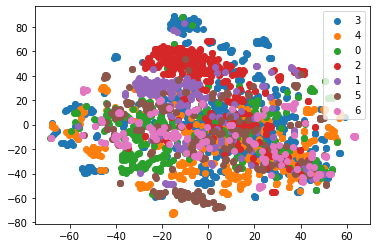

In [139]:
X, y = read_node_label(labels)

model = MultiClassifier(embeddings, LogisticRegression())

model.evaluate_hold_out(X, y)

plot_embeddings(embeddings, X, y)